In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
%%time
opt_parms = { 'ovs': 4096,
             'surf_units': u.micron,
             'ca': 75,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')
oap=[]

for surface_name in oap_labels:
    n_step = 'OAP {0}'.format(surface_name)
    file_loc=data_folder+'oap{0}_{1}CA'.format(surface_name, opt_parms['ca'])
    # create the object
    opt = psd.surfPSD(surf_name = n_step)
    opt.open_surf(fileloc=file_loc+'_surf.fits', 
                  surf_units = opt_parms['surf_units'])
    opt.open_mask(fileloc=file_loc+'_mask.fits')
    opt.calc_psd(oversamp = opt_parms['ovs'], 
                 kmid_ll=opt_parms['kmid_ll'], 
                 khigh_ll=opt_parms['khigh_ll'])
    print('PSD for {0} complete'.format(n_step))
    opt.calc_psd_radial(ring_width=opt_parms['ring_width'],
                        kmin = opt.k_min)
    print('Radial profile for {0} complete\n'.format(n_step))
    oap.append(opt)

PSD for OAP A complete
Radial profile for OAP A complete

PSD for OAP B complete
Radial profile for OAP B complete

PSD for OAP C complete
Radial profile for OAP C complete

PSD for OAP D complete
Radial profile for OAP D complete

PSD for OAP E complete
Radial profile for OAP E complete

PSD for OAP F complete
Radial profile for OAP F complete

PSD for OAP G complete
Radial profile for OAP G complete

PSD for OAP H complete
Radial profile for OAP H complete

CPU times: user 19min 13s, sys: 7min 12s, total: 26min 25s
Wall time: 26min 11s


The average PSD is calculated by averaging all of the normalized PSDs, then multiplying by the average variance. Get the radial and rms value from the average PSD.

In [18]:
%%time
# calculate the average PSD
avg_var = np.mean([obj.var.value for obj in oap])*oap[0].var.unit
avg_rms = np.mean([obj.rms_tot.value for obj in oap])*oap[0].rms_tot.unit

# calculate the average psd and get the calculation from there
avg_psd = np.zeros_like(oap[0].psd_cal.value)
for n in range(0, len(oap_labels)):
    avg_psd += oap[n].psd_norm.value
avg_psd /= len(oap_labels)
avg_psd = avg_psd * avg_var.value * oap[0].psd_cal.unit

# now take the radial
avg_psd_k, avg_psd_radial = psd.do_psd_radial(psd_data=avg_psd, delta_k=oap[0].delta_k, 
                                              ring_width=opt_parms['ring_width'], kmin=oap[0].k_min)

CPU times: user 3min 1s, sys: 1min 6s, total: 4min 8s
Wall time: 4min 8s


In [36]:
np.std(([obj.rms_tot.value for obj in oap]))

2.621754004115094

In [20]:
# calculate the average psd rms from the 2D PSD
avg_rms = psd.do_psd_rms(psd_data=avg_psd, delta_k=oap[0].delta_k, 
                         k_tgt_lim=(oap[0].k_min, oap[0].k_max), print_rms=True)

Target range - k_min: 26.394 1 / m and k_high: 2982.543 1 / m
RMS value: 22.8719 nm


## Plotting the PSDs

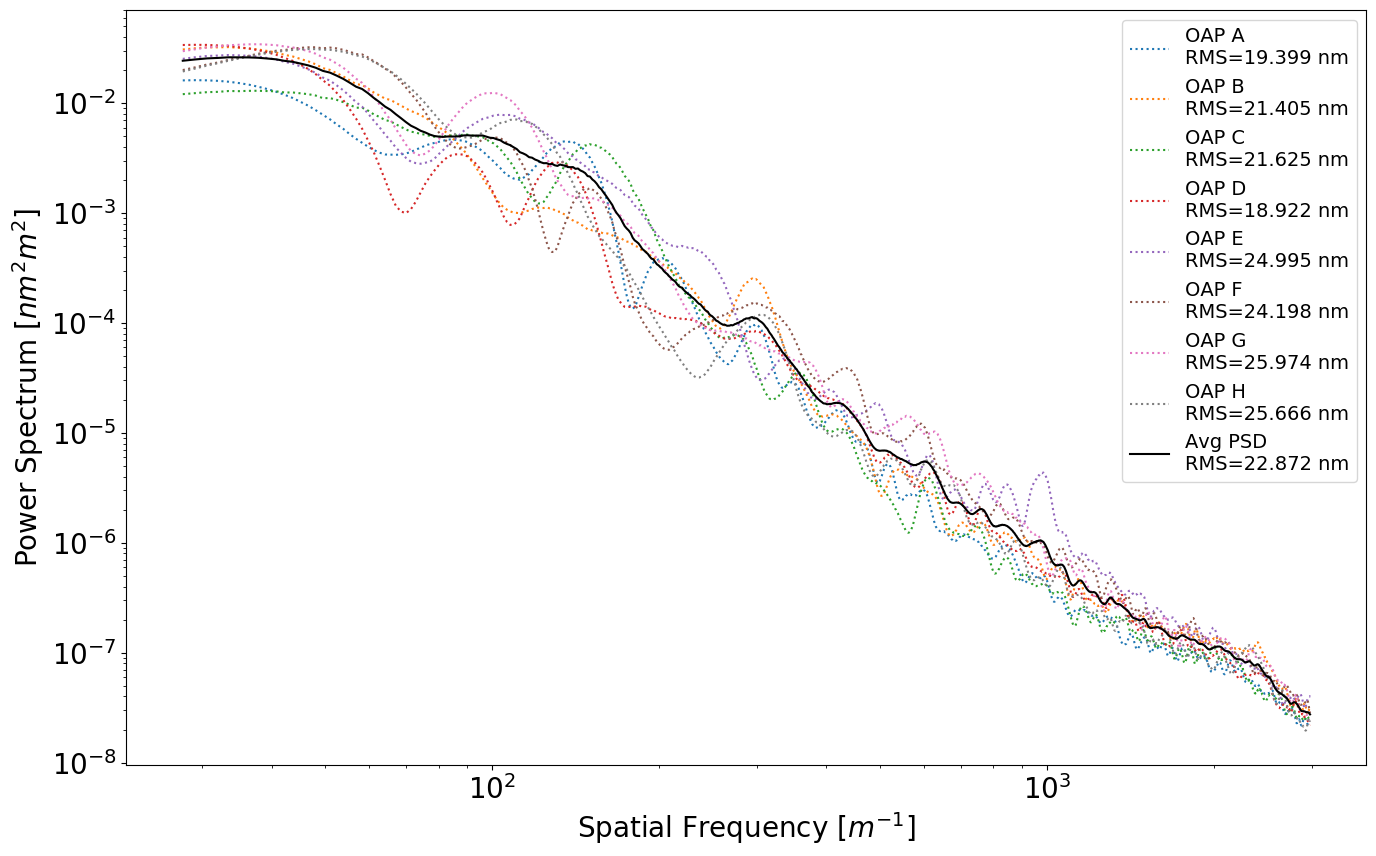

In [29]:
matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[16,10], dpi=100)
n = 1
for obj in oap:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', 
               label='{0}\nRMS={1:.3f}'.format(obj.surf_name, obj.rms_tot))
    n = n+1
plt.loglog(avg_psd_k.value, avg_psd_radial.value, 'k', 
           label='Avg PSD\nRMS={0:.3f}'.format(avg_rms))#, RMS={0:.3f}'.format(avg_rms))
plt.xlabel('Spatial Frequency [{0}]'.format(oap[0].k_radial.unit))
#plt.ylabel('PSD [{0}]'.format(str(psd_units)))#oap[0].psd_radial_cal.unit))
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
#plt.title('CACTI coated OAP PSD')
plt.legend(prop={'size':14})#,loc='center left', bbox_to_anchor=(1, 0.5))

## Calculate the RMS values
RMS values are scaled to the beam diameter (7.5mm) and calculated over the PSD region.

The WFE is the rms value for reflection and angle, which is the real rms that is seen by the mirror. Yes, it's supposed to be that ugly of a number. It is verified with the MagAO-X mirrors.

In [40]:
beam_diam = 7.5*u.mm
rms = []
wfe_rms = []
for j in range(0, len(oap)):
    kmin = 1/beam_diam.to(u.m)
    kmax = oap[j].k_max
    print('optic: {0}, beam_diam = {1:.7f}'.format(oap[j].surf_name, beam_diam))
    #print('kmin={1:.4f}'.format(beam_diam[j], kmin))
    rms_val = psd.do_psd_rms(psd_data=oap[j].psd_cal, delta_k=oap[j].delta_k, 
                             k_tgt_lim=[kmin, kmax], 
                             print_rms=False)
    print('RMS (no reflection): {0:.3f}'.format(rms_val))
    # calculate the wfe rms
    rms_wfe = rms_val * 2 / np.cos(7.5*u.deg)
    print('RMS (WFE, with half angle): {0:.3f}'.format(rms_wfe))
    rms.append(rms_val.value)
    wfe_rms.append(rms_wfe.value)
    print('-----')

optic: OAP A, beam_diam = 7.5000000 mm
RMS (no reflection): 11.570 nm
RMS (WFE, with half angle): 23.340 nm
-----
optic: OAP B, beam_diam = 7.5000000 mm
RMS (no reflection): 9.805 nm
RMS (WFE, with half angle): 19.779 nm
-----
optic: OAP C, beam_diam = 7.5000000 mm
RMS (no reflection): 14.221 nm
RMS (WFE, with half angle): 28.688 nm
-----
optic: OAP D, beam_diam = 7.5000000 mm
RMS (no reflection): 8.955 nm
RMS (WFE, with half angle): 18.064 nm
-----
optic: OAP E, beam_diam = 7.5000000 mm
RMS (no reflection): 13.908 nm
RMS (WFE, with half angle): 28.056 nm
-----
optic: OAP F, beam_diam = 7.5000000 mm
RMS (no reflection): 10.015 nm
RMS (WFE, with half angle): 20.203 nm
-----
optic: OAP G, beam_diam = 7.5000000 mm
RMS (no reflection): 10.584 nm
RMS (WFE, with half angle): 21.350 nm
-----
optic: OAP H, beam_diam = 7.5000000 mm
RMS (no reflection): 8.534 nm
RMS (WFE, with half angle): 17.216 nm
-----


In [41]:
(np.mean(rms), np.mean(wfe_rms))

(10.949042423956048, 22.08704255884557)

In [42]:
(np.std(rms), np.std(wfe_rms))

(1.9990912020194243, 4.032682562395561)

## Saving the data
Everything is saved as a .fits file. The 2D PSD file is very easy and fast to calculate, so I recommend running the code to get that. But the 1D radial PSD is very slow to calculate, so I'm going to save them as .fits files for easy reference.

In [45]:
for j in range(0, len(oap)):
    hdr = fits.Header()
    hdr['name'] = oap[j].surf_name
    hdr['psd_unit'] = (str(oap[j].psd_cal.unit), 'units for PSD data')
    hdr['diam_ca'] = (oap[j].diam_ca.value, 
                      'physical diameter for clear aperture [{0}]'.format(oap[j].diam_ca.unit))
    hdr['latres'] = (oap[j].latres.value,
                     'Lateral resolution of data [{0}]'.format(oap[j].latres.unit))
    hdr['delta_k'] = (oap[j].delta_k.value,
                 'spatial frequency resolution at PSD [{0}]'.format(oap[j].delta_k.unit))
    hdr['rms_tot'] = (oap[j].rms_tot.value,
                      'total clear aperture rms [{0}]'.format(oap[j].rms_tot.unit))
    hdr['d_beam'] = (beam_diam.value,
                     'CACTI beam diameter [{0}]'.format(beam_diam.unit))
    hdr['rms_beam'] = (rms[j], 
                       'CACTI beam diameter rms [nm]')
    hdr['oap_ang'] = (7.5, 
                      'OAP half angle [deg]')
    hdr['rms_opd'] = (wfe_rms[j],
                      'OPD rms at beam diam with oap_ang [nm]')
    hdr['comment'] = 'First row is spatial freq [{0}]'.format(oap[j].k_radial.unit)
    hdr['comment'] = 'Second row is radial PSD units [{0}]'.format(oap[j].psd_radial_cal.unit)
    
    fits_data = np.zeros((2, len(oap[j].k_radial)))
    fits_data[0] = oap[j].k_radial.value
    fits_data[1] = oap[j].psd_radial_cal.value
    
    fits.writeto('radial/psd_radial_oap{0}.fits'.format(oap_labels[j]),
                 fits_data, hdr, overwrite=True)

In [47]:
j = 0
hdr = fits.Header()
hdr['name'] = 'Avg_OAP'
hdr['psd_unit'] = (str(oap[j].psd_cal.unit), 'units for PSD data')
hdr['diam_ca'] = (oap[j].diam_ca.value, 
                  'physical diameter for clear aperture [{0}]'.format(oap[j].diam_ca.unit))
hdr['latres'] = (oap[j].latres.value,
                 'Lateral resolution of data [{0}]'.format(oap[j].latres.unit))
hdr['delta_k'] = (oap[j].delta_k.value,
             'spatial frequency resolution at PSD [{0}]'.format(oap[j].delta_k.unit))
hdr['rms_tot'] = (avg_rms.value,
                  'total clear aperture rms [{0}]'.format(avg_rms.unit))
hdr['d_beam'] = (beam_diam.value,
                 'CACTI beam diameter [{0}]'.format(beam_diam.unit))
hdr['rms_beam'] = (np.mean(rms), 
                   'CACTI beam diameter rms [nm]')
hdr['oap_ang'] = (7.5, 
                  'OAP half angle [deg]')
hdr['rms_opd'] = (np.mean(wfe_rms),
                  'OPD rms at beam diam with oap_ang [nm]')
hdr['comment'] = 'This is the average OAP PSD data.'
hdr['comment'] = 'First row is spatial freq [{0}]'.format(avg_psd_k.unit)
hdr['comment'] = 'Second row is radial PSD units [{0}]'.format(avg_psd_radial.unit)

fits_data = np.zeros((2, len(oap[j].k_radial)))
fits_data[0] = avg_psd_k.value
fits_data[1] = avg_psd_radial.value

fits.writeto('radial/psd_radial_oapAVG.fits',
             fits_data, hdr, overwrite=True)